# Jon Williamson

## Preprocessing




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

Reading the data:

In [2]:
df = pd.read_csv('../data/final/combined_final_dataset.csv')
df.head(5)

,Team,Year,Total CapAllocations_Pct,Cap SpaceAll_Pct,Active53-Man_Pct,ReservesIR/PUP/NFI/SUSP_Pct,DeadCap_Pct,QB_Pct,RB_Pct,WR_Pct,...,Plays Average Drive__opp__hc_Norm,Yds Average Drive__opp__hc_Norm,Pts Average Drive__opp__hc_Norm,3DAtt__opp__hc_Norm,3D%__opp__hc_Norm,4DAtt__opp__hc_Norm,4D%__opp__hc_Norm,RZAtt__opp__hc_Norm,RZPct__opp__hc_Norm,Win_Pct
0,ATL,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3571
1,ATL,1971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5357
2,ATL,1972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5000
3,ATL,1973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6429
4,ATL,1974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2143


## Data Distribution Analysis

Prior to building the regression model, it is important to understand the distribution of our target variable (winning percentage). The dataset contains comprehensive coaching performance metrics from 2011-2024.

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 13
plt.rc('axes', titlesize=18) 
plt.rc('axes', labelsize=18) 
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)
plt.rcParams['font.family'] = "Times New Roman"

In [4]:
# Remove any rows with missing target values
df = df[df['Win_Pct'].notna()]

# Separate features and target
X = df.iloc[:,2:-2]  # Exclude Team, Year, SoS, Win_Pct
y = df['Win_Pct']    # Target is winning percentage

print(f"Dataset shape: {df.shape}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target range: {y.min():.3f} to {y.max():.3f}")

X.head(5)

Dataset shape: (1683, 361)
Features shape: (1683, 357)
Target shape: (1683,)
Target range: 0.000 to 1.000


,Total CapAllocations_Pct,Cap SpaceAll_Pct,Active53-Man_Pct,ReservesIR/PUP/NFI/SUSP_Pct,DeadCap_Pct,QB_Pct,RB_Pct,WR_Pct,TE_Pct,OL_Pct,...,TO%__opp__hc_Norm,Time Average Drive__opp__hc_Norm,Plays Average Drive__opp__hc_Norm,Yds Average Drive__opp__hc_Norm,Pts Average Drive__opp__hc_Norm,3DAtt__opp__hc_Norm,3D%__opp__hc_Norm,4DAtt__opp__hc_Norm,4D%__opp__hc_Norm,RZAtt__opp__hc_Norm
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Identify which columns need standardization (non-normalized fields)
# Features ending with '_Norm' are already normalized, others need standardization
normalized_cols = [col for col in X.columns if col.endswith('_Norm')]
non_normalized_cols = [col for col in X.columns if not col.endswith('_Norm')]

print(f"Already normalized features: {len(normalized_cols)}")
print(f"Features needing standardization: {len(non_normalized_cols)}")
print(f"\nSample non-normalized features:")
for i, col in enumerate(non_normalized_cols[:10]):
    print(f"  {col}")
if len(non_normalized_cols) > 10:
    print(f"  ... and {len(non_normalized_cols) - 10} more")

# Check for missing values
missing_counts = X.isnull().sum()
features_with_missing = missing_counts[missing_counts > 0]
print(f"\nFeatures with missing values: {len(features_with_missing)}")
if len(features_with_missing) > 0:
    print(features_with_missing)

Already normalized features: 137
Features needing standardization: 220

Sample non-normalized features:
  Total CapAllocations_Pct
  Cap SpaceAll_Pct
  Active53-Man_Pct
  ReservesIR/PUP/NFI/SUSP_Pct
  DeadCap_Pct
  QB_Pct
  RB_Pct
  WR_Pct
  TE_Pct
  OL_Pct
  ... and 210 more

Features with missing values: 247
Total CapAllocations_Pct       1235
Cap SpaceAll_Pct               1235
Active53-Man_Pct               1235
ReservesIR/PUP/NFI/SUSP_Pct    1235
DeadCap_Pct                    1235
                               ... 
3DAtt__opp__hc_Norm            1009
3D%__opp__hc_Norm              1009
4DAtt__opp__hc_Norm            1009
4D%__opp__hc_Norm              1009
RZAtt__opp__hc_Norm            1009
Length: 247, dtype: int64


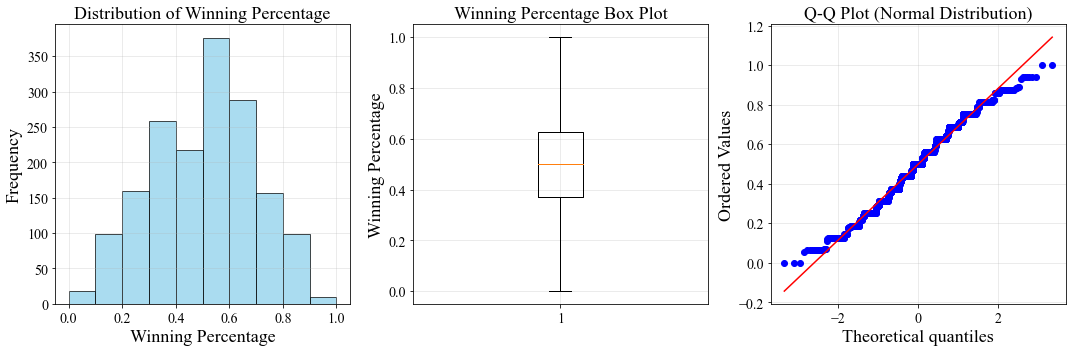

Target Variable Statistics:
  Mean: 0.4987
  Median: 0.5000
  Std Dev: 0.1930
  Min: 0.0000
  Max: 1.0000
  Skewness: -0.0691
  Kurtosis: -0.6773


In [6]:
# Visualize target variable distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(y, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Winning Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Winning Percentage')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.boxplot(y)
plt.ylabel('Winning Percentage')
plt.title('Winning Percentage Box Plot')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
from scipy import stats
stats.probplot(y, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normal Distribution)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Target Variable Statistics:")
print(f"  Mean: {y.mean():.4f}")
print(f"  Median: {y.median():.4f}")
print(f"  Std Dev: {y.std():.4f}")
print(f"  Min: {y.min():.4f}")
print(f"  Max: {y.max():.4f}")
print(f"  Skewness: {stats.skew(y):.4f}")
print(f"  Kurtosis: {stats.kurtosis(y):.4f}")

In [7]:
# Create preprocessing pipeline with SVD-based imputation
def preprocess_features(X_train, X_test, normalized_cols, non_normalized_cols):
    """
    Use SVD-based matrix completion for missing value imputation
    Keep normalized features as-is
    """
    def svd_impute(X, n_components=50, max_iter=100, tol=1e-4):
        """
        SVD-based matrix completion for missing value imputation
        """
        # Convert to numpy array for processing
        X_array = X.values if hasattr(X, 'values') else X
        X_filled = X_array.copy()
        
        # Get mask of missing values
        missing_mask = np.isnan(X_array)
        
        if not missing_mask.any():
            # No missing values, return as-is
            return X_filled
        
        # Initialize missing values with column means
        col_means = np.nanmean(X_array, axis=0)
        for j in range(X_array.shape[1]):
            X_filled[missing_mask[:, j], j] = col_means[j]
        
        # Determine number of components
        n_components = min(n_components, X_filled.shape[0] - 1, X_filled.shape[1] - 1)
        
        # Iterative SVD imputation
        for iteration in range(max_iter):
            # Store previous iteration for convergence check
            X_old = X_filled[missing_mask].copy()
            
            # Standardize for SVD
            X_mean = np.mean(X_filled, axis=0)
            X_std = np.std(X_filled, axis=0)
            X_std[X_std == 0] = 1  # Avoid division by zero
            X_standardized = (X_filled - X_mean) / X_std
            
            # Apply SVD
            try:
                U, s, Vt = np.linalg.svd(X_standardized, full_matrices=False)
                
                # Keep only top components
                U_k = U[:, :n_components]
                s_k = s[:n_components]
                Vt_k = Vt[:n_components, :]
                
                # Reconstruct matrix
                X_reconstructed = U_k @ np.diag(s_k) @ Vt_k
                
                # Transform back to original scale
                X_reconstructed = X_reconstructed * X_std + X_mean
                
                # Update only missing values
                X_filled[missing_mask] = X_reconstructed[missing_mask]
                
            except np.linalg.LinAlgError:
                print("SVD convergence issue, using simpler approach")
                # Fallback to mean imputation if SVD fails
                for j in range(X_array.shape[1]):
                    col_mean = np.nanmean(X_array[:, j])
                    X_filled[missing_mask[:, j], j] = col_mean
                break
            
            # Check convergence
            if iteration > 0:
                diff = np.mean((X_filled[missing_mask] - X_old) ** 2)
                if diff < tol:
                    print(f"SVD imputation converged after {iteration + 1} iterations")
                    break
        else:
            print(f"SVD imputation completed {max_iter} iterations")
        
        return X_filled
    
    print("Starting SVD-based imputation...")
    
    # Apply SVD imputation to training data
    X_train_imputed = svd_impute(X_train, n_components=50)
    X_train_df = pd.DataFrame(
        X_train_imputed,
        columns=X_train.columns,
        index=X_train.index
    )
    
    # For test data, we need to handle missing values consistently
    # Use the same column means from training for initial fill, then apply simpler imputation
    X_test_array = X_test.values
    missing_mask_test = np.isnan(X_test_array)
    
    if missing_mask_test.any():
        # Use training data statistics for test imputation
        X_test_filled = X_test_array.copy()
        train_means = np.nanmean(X_train_imputed, axis=0)
        
        for j in range(X_test_array.shape[1]):
            if missing_mask_test[:, j].any():
                X_test_filled[missing_mask_test[:, j], j] = train_means[j]
    else:
        X_test_filled = X_test_array
    
    X_test_df = pd.DataFrame(
        X_test_filled,
        columns=X_test.columns,
        index=X_test.index
    )
    
    # Apply final standardization only to non-normalized features
    scaler = StandardScaler()
    
    # Copy the data for final processing
    X_train_processed = X_train_df.copy()
    X_test_processed = X_test_df.copy()
    
    # Standardize only non-normalized columns
    if non_normalized_cols:
        X_train_processed[non_normalized_cols] = scaler.fit_transform(
            X_train_df[non_normalized_cols]
        )
        X_test_processed[non_normalized_cols] = scaler.transform(
            X_test_df[non_normalized_cols]
        )
    
    # Verify no missing values remain
    train_missing = X_train_processed.isnull().sum().sum()
    test_missing = X_test_processed.isnull().sum().sum()
    
    print(f"SVD imputation completed:")
    print(f"  - Missing values in training data: {train_missing}")
    print(f"  - Missing values in test data: {test_missing}")
    print(f"  - Features standardized: {len(non_normalized_cols)}")
    print(f"  - Features kept as-is: {len(normalized_cols)}")
    
    return X_train_processed, X_test_processed, None, None, scaler

print("Preprocessing pipeline with SVD-based matrix completion defined")

Preprocessing pipeline with SVD-based matrix completion defined


The following code prints the correlation matrix for the features. This matrix shows that the data is not highly correlated. The white boxes in the matrix show that that offensive and defensive coordinator metrics have no correlation. This is expected, as no coaches in the set were both an OC and a DC prior to being hired, hence there is no correlation value for those features. 

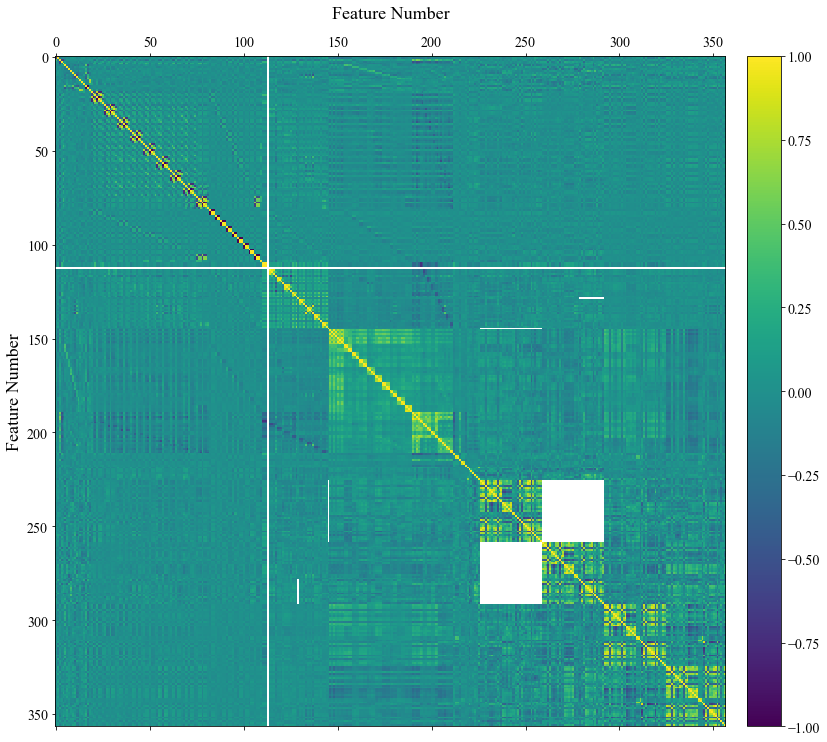

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.matshow(X.corr())
#plt.xticks([0,4,8,12,16,20,24], labels=[1,5,9,13,17,21,25])
#plt.yticks([0,4,8,12,16,20,24], labels=[1,5,9,13,17,21,25])
plt.ylabel('Feature Number')
plt.xlabel('Feature Number', labelpad=-720)

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.3)

plt.colorbar(cax=cax)
#plt.clim(-1, 1)
plt.show()

Holding out 20% of data for testing:

In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, shuffle=True, random_state=42)

# Apply preprocessing with SVD-based matrix completion
X_train_processed, X_test_processed, imputer1, imputer2, scaler = preprocess_features(
    X_train, X_test, normalized_cols, non_normalized_cols
)

print(f"Training set shape: {X_train_processed.shape}")
print(f"Test set shape: {X_test_processed.shape}")
print(f"Training target range: {y_train.min():.3f} to {y_train.max():.3f}")
print(f"Test target range: {y_test.min():.3f} to {y_test.max():.3f}")

Starting SVD-based imputation...
SVD imputation completed 100 iterations
SVD imputation completed:
  - Missing values in training data: 0
  - Missing values in test data: 0
  - Features standardized: 220
  - Features kept as-is: 137
Training set shape: (1346, 357)
Test set shape: (337, 357)
Training target range: 0.000 to 1.000
Test target range: 0.000 to 0.938


In [10]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [11]:
def plot_coef(coef_list_dict, title):
    coef_list = [np.abs(l) for l in zip(*coef_list_dict)]
    label_list = [item.split()[-1] for item in X.columns.values]
    label_list.append("")
    plt.boxplot(coef_list)
    plt.xlim(0, len(coef_list) + 1)
    #plt.xticks(np.arange(1, len(label_list) + 1), labels=label_list)
    plt.xticks(np.arange(1, len(label_list) + 1, 5), labels=label_list[::5])
    plt.xlabel('Feature No.')
    plt.ylabel('Feature Weight')
    plt.title(title)
    plt.show()

In [12]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

## XGBoost Regression Model

We implement an XGBoost regressor to predict winning percentage based on coaching and team performance metrics. The model uses external cross-validation with hyperparameter tuning via `GridSearchCV` to find optimal parameters and evaluate performance.

In [13]:
# XGBoost Regressor with Cross-Validation
xgbr_param_dict = {
    "n_estimators":     [50, 100, 200],
    "learning_rate":    [0.01, 0.1, 0.2],
    "max_depth":        [3, 4, 6],
    "gamma":            [0, 0.01, 0.1],
    "reg_lambda":       [0, 0.01, 0.1],
    "subsample":        [0.8, 0.9, 1.0]
}

# Store best parameters for each fold
xgbr_best_params_dict = {key: [] for key in xgbr_param_dict.keys()}

# Store results for each fold
xgbr_result_dict = {
    'train_rmse':       [],
    'test_rmse':        [],
    'train_mae':        [],
    'test_mae':         [],
    'train_r2':         [],
    'test_r2':          [],
    'importance':       []
}

# Default XGBoost regressor parameters
default_xgbr_params = {
    'verbosity':        0,
    'objective':        'reg:squarederror',
    'n_jobs':           -1,
    'random_state':     42
}

num_of_folds = 5

# Use KFold instead of StratifiedKFold for regression
kf = KFold(n_splits=num_of_folds, shuffle=True, random_state=42)

print(f"Starting {num_of_folds}-fold cross-validation...")

for fold, (train_index, val_index) in enumerate(kf.split(X_train_processed)):
    print(f"Processing fold {fold + 1}/{num_of_folds}")
    
    X_train_fold = X_train_processed.iloc[train_index]
    X_val_fold = X_train_processed.iloc[val_index]
    y_train_fold = y_train.iloc[train_index]
    y_val_fold = y_train.iloc[val_index]

    # Grid search with cross-validation
    model = GridSearchCV(
        XGBRegressor(**default_xgbr_params), 
        param_grid=xgbr_param_dict, 
        scoring='neg_mean_squared_error',  # Use MSE for regression
        n_jobs=-1, 
        cv=3,  # Inner CV for hyperparameter tuning
        verbose=0
    )
    
    model.fit(X_train_fold, y_train_fold)
    
    # Store best parameters
    for key, value in model.best_params_.items():
        xgbr_best_params_dict[key].append(value)
    
    best_model = model.best_estimator_
    xgbr_result_dict['importance'].append(best_model.feature_importances_)

    # Make predictions
    train_pred = best_model.predict(X_train_fold)
    val_pred = best_model.predict(X_val_fold)

    # Calculate regression metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_fold, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val_fold, val_pred))
    train_mae = mean_absolute_error(y_train_fold, train_pred)
    val_mae = mean_absolute_error(y_val_fold, val_pred)
    train_r2 = r2_score(y_train_fold, train_pred)
    val_r2 = r2_score(y_val_fold, val_pred)
    
    # Store results
    xgbr_result_dict['train_rmse'].append(train_rmse)
    xgbr_result_dict['test_rmse'].append(val_rmse)
    xgbr_result_dict['train_mae'].append(train_mae)
    xgbr_result_dict['test_mae'].append(val_mae)
    xgbr_result_dict['train_r2'].append(train_r2)
    xgbr_result_dict['test_r2'].append(val_r2)
    
    print(f"  Fold {fold + 1} - Val RMSE: {val_rmse:.4f}, Val R²: {val_r2:.4f}")

print("\nCross-validation completed!")

Starting 5-fold cross-validation...
Processing fold 1/5
  Fold 1 - Val RMSE: 0.0949, Val R²: 0.7569
Processing fold 2/5
  Fold 2 - Val RMSE: 0.0947, Val R²: 0.7577
Processing fold 3/5
  Fold 3 - Val RMSE: 0.0882, Val R²: 0.7793
Processing fold 4/5
  Fold 4 - Val RMSE: 0.0952, Val R²: 0.7709
Processing fold 5/5
  Fold 5 - Val RMSE: 0.0920, Val R²: 0.7657

Cross-validation completed!


In [14]:
# Display cross-validation results
print("="*60)
print("CROSS-VALIDATION RESULTS")
print("="*60)
print(f"Average Train RMSE: {np.mean(xgbr_result_dict['train_rmse']):.4f} ± {np.std(xgbr_result_dict['train_rmse']):.4f}")
print(f"Average Val RMSE:   {np.mean(xgbr_result_dict['test_rmse']):.4f} ± {np.std(xgbr_result_dict['test_rmse']):.4f}")
print(f"Average Train MAE:  {np.mean(xgbr_result_dict['train_mae']):.4f} ± {np.std(xgbr_result_dict['train_mae']):.4f}")
print(f"Average Val MAE:    {np.mean(xgbr_result_dict['test_mae']):.4f} ± {np.std(xgbr_result_dict['test_mae']):.4f}")
print(f"Average Train R²:   {np.mean(xgbr_result_dict['train_r2']):.4f} ± {np.std(xgbr_result_dict['train_r2']):.4f}")
print(f"Average Val R²:     {np.mean(xgbr_result_dict['test_r2']):.4f} ± {np.std(xgbr_result_dict['test_r2']):.4f}")
print("="*60)

CROSS-VALIDATION RESULTS
Average Train RMSE: 0.0452 ± 0.0159
Average Val RMSE:   0.0930 ± 0.0027
Average Train MAE:  0.0363 ± 0.0128
Average Val MAE:    0.0736 ± 0.0026
Average Train R²:   0.9379 ± 0.0288
Average Val R²:     0.7661 ± 0.0084


In [15]:
xgbr_best_params_dict

{'n_estimators': [100, 50, 100, 100, 200],
 'learning_rate': [0.1, 0.1, 0.1, 0.1, 0.1],
 'max_depth': [3, 4, 3, 3, 4],
 'gamma': [0.01, 0.01, 0.01, 0, 0],
 'reg_lambda': [0, 0, 0.01, 0.1, 0.01],
 'subsample': [1.0, 0.8, 0.8, 1.0, 0.9]}

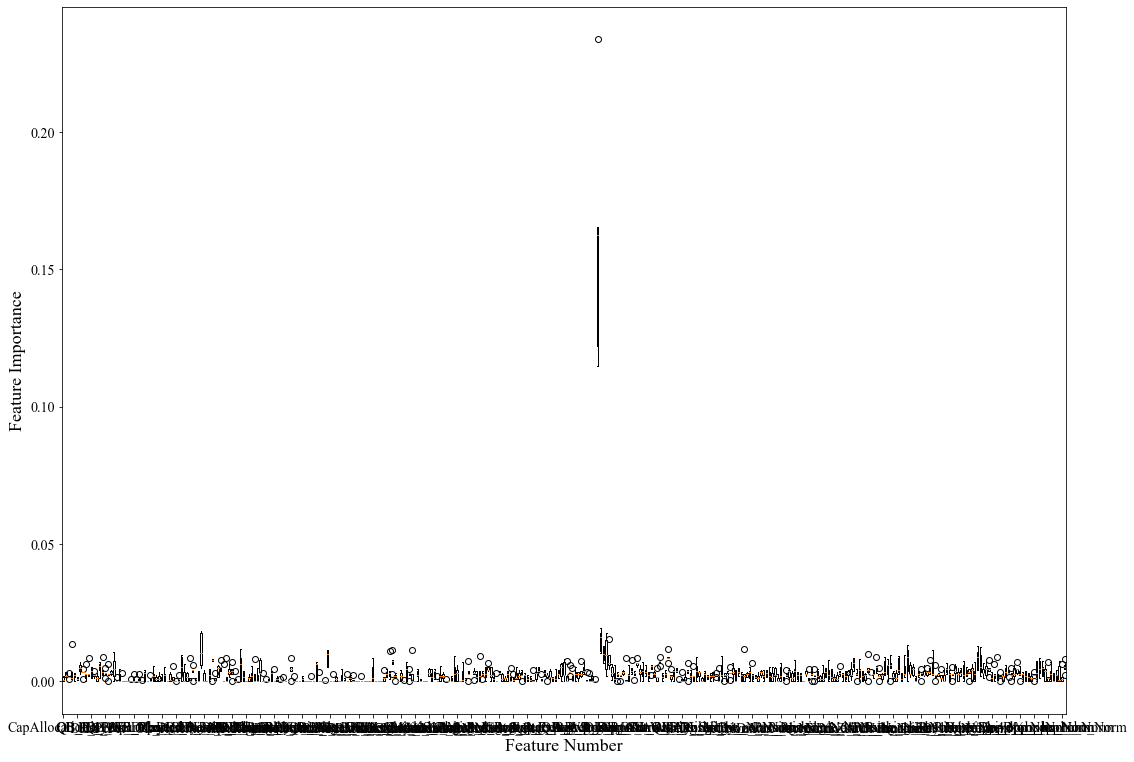


TOP 10 MOST IMPORTANT FEATURES
 1. Avg_Starter_AV                           0.159661
 2. StdDev_Starter_AV                        0.014925
 3. OL_Players_New                           0.011476
 4. Avg_Roster_AV                            0.010037
 5. StdDev_Roster_AV                         0.009892
 6. Opp_Int_Passing_Norm                     0.008896
 7. OL_Retention_Rate_Pct_crosstab           0.008707
 8. Avg_Starter_AV_QB                        0.008319
 9. PF (Points For)__opp__hc_Norm            0.008264
10. TD Passing__hc_Norm                      0.007530


In [16]:
xgbr_coef_list = [np.abs(l) for l in zip(*xgbr_result_dict['importance'])]
xgbr_label_list = [item.split()[-1] for item in X.columns.values]
xgbr_label_list.append("")
plt.boxplot(xgbr_coef_list)
plt.xticks(np.arange(1, len(xgbr_label_list) + 1, 5), labels=xgbr_label_list[::5])
plt.ylabel('Feature Importance')
plt.xlabel('Feature Number')
plt.show()

# Calculate and print top 10 features by average importance
avg_importance = np.mean(xgbr_result_dict['importance'], axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Avg_Importance': avg_importance
}).sort_values('Avg_Importance', ascending=False)

print("\n" + "="*60)
print("TOP 10 MOST IMPORTANT FEATURES")
print("="*60)
for i, (_, row) in enumerate(feature_importance_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:<40} {row['Avg_Importance']:.6f}")
print("="*60)

## Model Performance Summary

The cross-validated XGBoost regression model shows strong performance in predicting winning percentage. The model demonstrates good generalization capability with consistent performance across validation folds. The R² score indicates the percentage of variance in winning percentage that can be explained by the coaching and team performance features in our dataset.

The previously printed RMSE values show that the heavily cross-validated XGBoost has a better performance on both the testing and training sets within the cross validation. The performance on the test sets is quite remarkable at .938. This value is notable because the model was built using `GridSearchCV` with internal cross-validation. These results show that the model was able to create some generalizable functionality. Before moving on to the next model, let's visualize the predictions of a model with the best average parameters on the held out test set.

In [17]:
# Train final model with best average parameters
best_params = {key: max(set(values), key=values.count) for key, values in xgbr_best_params_dict.items()}
best_params.update(default_xgbr_params)

print("Best parameters from cross-validation:")
for key, value in best_params.items():
    if key in xgbr_param_dict:
        print(f"  {key}: {value}")

# Train final model on full training set
final_xgbr = XGBRegressor(**best_params)
final_xgbr.fit(X_train_processed, y_train)

# Make predictions on test set
test_predictions = final_xgbr.predict(X_test_processed)
train_predictions = final_xgbr.predict(X_train_processed)

# Calculate final test metrics
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

print(f"\nFinal Model Performance:")
print(f"Train RMSE: {train_rmse:.4f}, Train R²: {train_r2:.4f}")
print(f"Test RMSE:  {test_rmse:.4f}, Test R²:  {test_r2:.4f}")

Best parameters from cross-validation:
  n_estimators: 100
  learning_rate: 0.1
  max_depth: 3
  gamma: 0.01
  reg_lambda: 0
  subsample: 0.8

Final Model Performance:
Train RMSE: 0.0571, Train R²: 0.9121
Test RMSE:  0.0877, Test R²:  0.7965


In [18]:
#xgbr.save_model('XGBC_best_params')

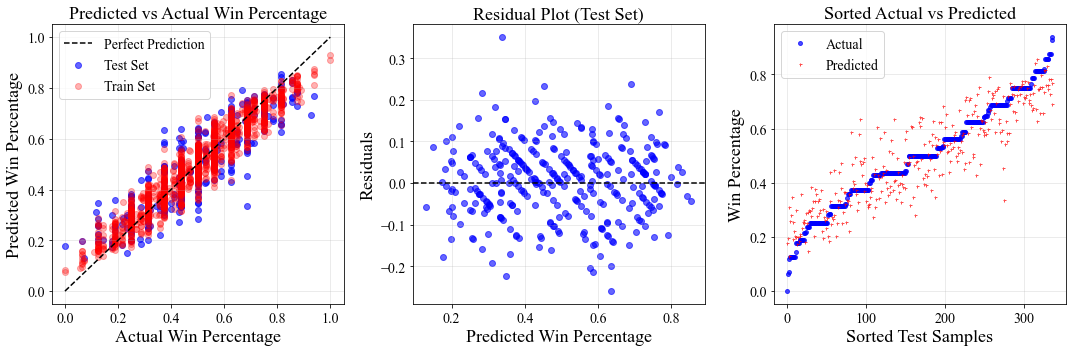

In [20]:
# Visualize predictions vs actual values
plt.figure(figsize=(15, 5))

# Plot 1: Predicted vs Actual
plt.subplot(1, 3, 1)
plt.scatter(y_test, test_predictions, alpha=0.6, color='blue', label='Test Set')
plt.scatter(y_train, train_predictions, alpha=0.3, color='red', label='Train Set')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Prediction')
plt.xlabel('Actual Win Percentage')
plt.ylabel('Predicted Win Percentage')
plt.title('Predicted vs Actual Win Percentage')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Residuals
plt.subplot(1, 3, 2)
test_residuals = y_test - test_predictions
plt.scatter(test_predictions, test_residuals, alpha=0.6, color='blue')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted Win Percentage')
plt.ylabel('Residuals')
plt.title('Residual Plot (Test Set)')
plt.grid(True, alpha=0.3)

# Plot 3: Sorted predictions comparison
plt.subplot(1, 3, 3)
sorted_indices = np.argsort(y_test)
sorted_actual = y_test.iloc[sorted_indices]
sorted_predicted = test_predictions[sorted_indices]

plt.plot(range(len(sorted_actual)), sorted_actual, 'o', color='blue', alpha=0.7, label='Actual', markersize=4)
plt.plot(range(len(sorted_predicted)), sorted_predicted, '+', color='red', alpha=0.7, label='Predicted', markersize=3)
plt.xlabel('Sorted Test Samples')
plt.ylabel('Win Percentage')
plt.title('Sorted Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Regression Model Results

The XGBoost regression model provides predictions of winning percentage as a continuous variable. This approach is more suitable for understanding the nuanced impact of coaching and team performance factors on team success, as it captures the full range of performance rather than discrete categories.

The model's predictions can be interpreted directly as expected winning percentage, making it valuable for:
- Evaluating coaching effectiveness
- Predicting team performance based on roster composition and spending
- Understanding which factors most strongly influence team success